<a href="https://colab.research.google.com/github/glarmour/Congressional-Analytics/blob/main/GSB_521_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greg Larmour
# Harrison Pearce


GSB 521 - Pierce

# Questions to Analyze:

1. Are Democrats Or Republicans Better Investors?

2. Did Democrats or Republicans Recieve More COVID Unemployment Funding?

In [57]:
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt

We will first collect data from the census on household incomes for every congressional dsitrict in each state. 

In [58]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"
response = urlopen(url)
data_json = json.loads(response.read())
data_json.pop(0) 
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

We will clean our congressional income data below.

In [59]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() 
party_df = party_df[['State', 'Party', "district number"]]

In [60]:
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

We will now import our data from the Social Security Department.

In [61]:
social_df = pd.read_csv("https://www.irs.gov/pub/irs-soi/20incd.csv")

Our data needs to be cleaned so we can merge it with our political party data set and our congressional income data set. This is done below by converting each State abbreviation to the state's full name.

In [62]:

state_abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 
                     'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 
                     'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 
                     'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
                     'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
                     'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
                     'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
                     'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 
                     'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 
                     'WI': 'Wisconsin', 'WY': 'Wyoming'}
social_df['State'] = social_df['STATE'].map(state_abbr_to_name)
social_df['district number'] = social_df['CONG_DISTRICT']

In [63]:
merged_df_final = pd.merge(merged_df, social_df, on=["State", "district number"])                           
merged_df_final['Number of Farm Returns']  = merged_df_final["SCHF"]
merged_df_final['Net Capital Gain (Or Loss)']  = merged_df_final["A01000"]
merged_df_final["COVID Unemployment Compensation Amount"] = merged_df_final["A02300"]
merged_df_final['Total Income'] = merged_df_final['A02650']


# PLOT 1 :

Number of Farm Returns Per County vs. % Households over $200k

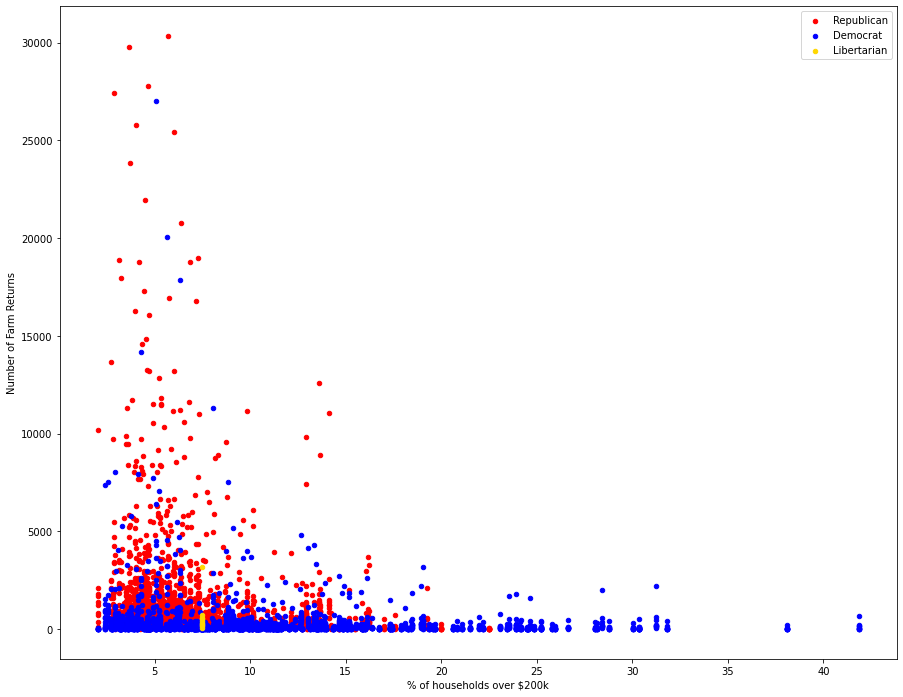

In [65]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='Number of Farm Returns', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='Number of Farm Returns',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='Number of Farm Returns',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

# PLOT 2 :

Number of Farm Returns Per County vs. Total District Income

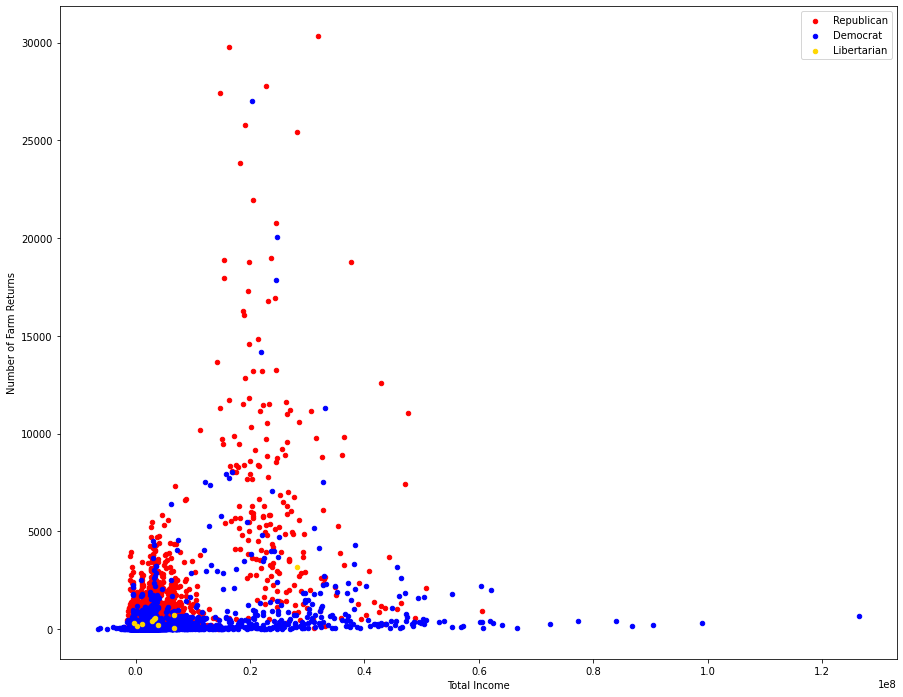

In [66]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y='Number of Farm Returns', c='red',label='Republican', ax=ax)
D.plot.scatter(x='Total Income', y='Number of Farm Returns',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Total Income', y='Number of Farm Returns',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

# PLOT 3 :

Net Capital Gain (Or Loss) Per District vs. Total District Income

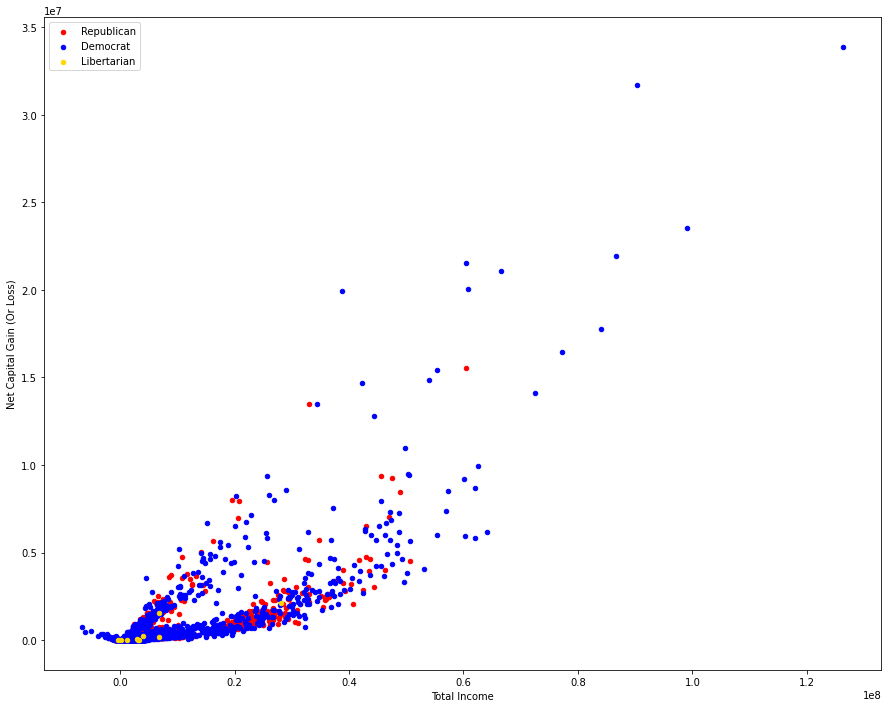

In [67]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)', c='red',label='Republican', ax=ax)
D.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

As income increases, Net Capital Gain in each county exponentially increases. This is especially shown in Democratic Counties. On average, it appears that for larger income areas, Capital Gains from investments are larger as well. 

# PLOT 4 :

COVID Unemployment Compensation Amount ($) vs. Total District Income

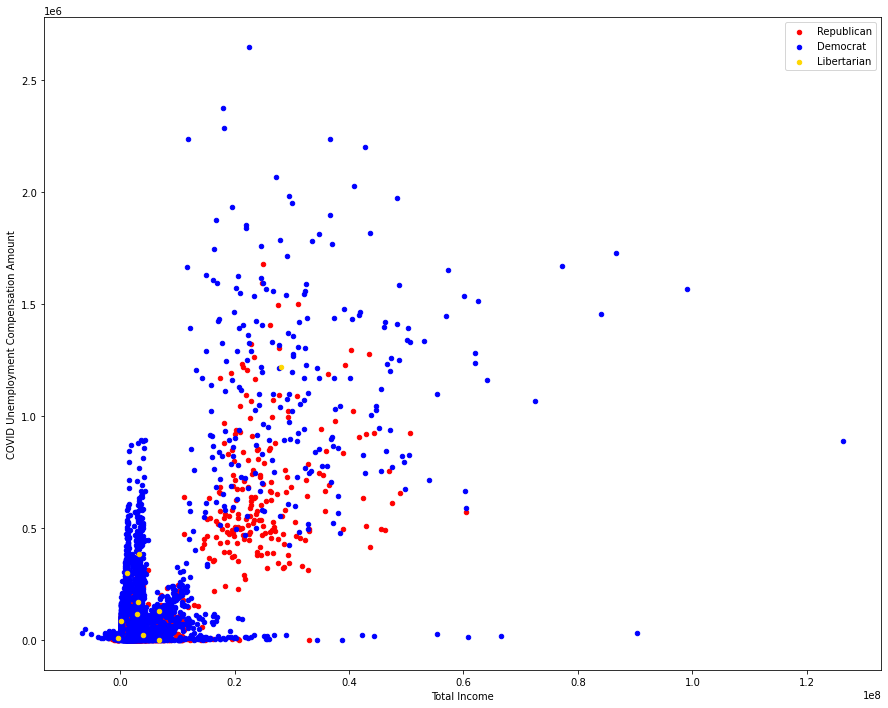

In [68]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount", c='red',label='Republican', ax=ax)
D.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount",c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount",c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

Interestingly enough, as Total County income increased, the amount of COVID unemployment compensation also increased. This Unemployment Compensation was greater in Low income areas for Democratic Counties. The compensation was also greater in High income areas for Democratic Counties.